In [1]:
import numpy as np

In [8]:
import torch
from torch import nn
from CCN.ccn.constraints_layer import ConstraintsLayer
from CCN.ccn.constraints_group import ConstraintsGroup
from CCN.ccn.constraint import Constraint
from CCN.ccn.clauses_group import ClausesGroup


In [9]:
with open('spmll/rules.txt', 'r') as f:
    print(f.readlines())
    for line in f:
        print(line)

['20 :- 0\n', '20 :- 1\n', '20 :- 3\n', '20 :- 5\n', '20 :- 6\n', '20 :- 13\n', '20 :- 18\n', '21 :- 2\n', '21 :- 7\n', '21 :- 9\n', '21 :- 11\n', '21 :- 12\n', '21 :- 16\n', '22 :- 4\n', '22 :- 8\n', '22 :- 10\n', '22 :- 15\n', '22 :- 17\n', '22 :- 19']


In [12]:
rules_path = "spmll/rules.txt"
group   = ConstraintsGroup(rules_path)
clauses = ClausesGroup.from_constraints_group(group)
layer   = ConstraintsLayer.from_clauses_group(clauses, num_classes=23, centrality="katz")

<generator object ConstraintsGroup.__init__.<locals>.<genexpr> at 0x000001C2C2C09F50>


In [11]:
group

In [13]:
id2name = {
    0:'aeroplane',1:'bicycle',2:'bird',3:'boat',4:'bottle',
    5:'bus',6:'car',7:'cat',8:'chair',9:'cow',
    10:'diningtable',11:'dog',12:'horse',13:'motorbike',14:'person',
    15:'pottedplant',16:'sheep',17:'sofa',18:'train',19:'tvmonitor', 20:'vehicle', 21:'animal', 22:'indoor'
}


In [ ]:
import torch
from torch import nn
from CCN.ccn.constraints_layer import ConstraintsLayer
from CCN.ccn.constraints_group import ConstraintsGroup
from CCN.ccn.constraint import Constraint
from CCN.ccn.clauses_group import ClausesGroup

rules_path = "spmll/rules.txt"
group   = ConstraintsGroup(rules_path)
clauses = ClausesGroup.from_constraints_group(group)
layer   = ConstraintsLayer.from_clauses_group(clauses, num_classes=23, centrality="katz")
torch.manual_seed(0)
preds = torch.rand(8, 23)
updated = layer(preds)
print("Coherent after layer? ", group.coherent_with(updated.cpu().numpy()).all())
print("Example (car→person) before/after: ")
i = 0
print("car,vehicle before:", preds[i,[6,20]].tolist())
print("car,vehicle after: ", updated[i,[6,20]].tolist())


Coherent after layer?  True
Example (car→person) before/after: 
car,vehicle before: [0.4900934100151062, 0.6816085577011108]
car,vehicle after:  [0.4900934100151062, 0.7682217955589294]


In [15]:
preds[0]

tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964, 0.4556,
        0.6323, 0.3489, 0.4017, 0.0223, 0.1689, 0.2939, 0.5185, 0.6977, 0.8000,
        0.1610, 0.2823, 0.6816, 0.9152, 0.3971])

In [16]:
for k, v in id2name.items():
    print(v, preds[0,k].item(), updated[0,k].item())


aeroplane 0.49625658988952637 0.49625658988952637
bicycle 0.7682217955589294 0.7682217955589294
bird 0.08847743272781372 0.08847743272781372
boat 0.13203048706054688 0.13203048706054688
bottle 0.30742281675338745 0.30742281675338745
bus 0.6340786814689636 0.6340786814689636
car 0.4900934100151062 0.4900934100151062
cat 0.8964447379112244 0.8964447379112244
chair 0.455627977848053 0.455627977848053
cow 0.6323062777519226 0.6323062777519226
diningtable 0.3488934636116028 0.3488934636116028
dog 0.40171730518341064 0.40171730518341064
horse 0.022325754165649414 0.022325754165649414
motorbike 0.16885894536972046 0.16885894536972046
person 0.2938884496688843 0.2938884496688843
pottedplant 0.518521785736084 0.518521785736084
sheep 0.6976675987243652 0.6976675987243652
sofa 0.800011396408081 0.800011396408081
train 0.16102945804595947 0.16102945804595947
tvmonitor 0.28226858377456665 0.28226858377456665
vehicle 0.6816085577011108 0.7682217955589294
animal 0.9151939749717712 0.9151939749717712


In [17]:
import torch
import numpy as np

def ratio_for_modules(layer, k_modules=1):
    """Smallest ratio that activates at least k_modules strata."""
    for r in [i/100 for i in range(0, 101)]:
        _, m = layer.gradual_prefix(r)
        if m >= k_modules:
            return r
    return 1.0  # fallback

def apply_constraints_safe(layer, group, probs, epoch, total_epochs,
                           start_ratio=0.30, end_ratio=1.00,
                           tau=0.70, delta_cap=0.15, min_modules=1):
    """
    Soft-ish enforcement:
      - curriculum with ≥min_modules active
      - goal-gating with threshold tau
      - delta cap to avoid big jumps
    """
    # curriculum ratio, but ensure >= min_modules
    raw_ratio = start_ratio + (end_ratio - start_ratio) * (epoch / max(1, total_epochs-1))
    need = ratio_for_modules(layer, min_modules)
    ratio = max(raw_ratio, need)
    slicer = layer.slicer(ratio)

    # goal-gating
    goal = (probs > tau).float()

    # run layer
    updated = layer(probs, goal=goal, slicer=slicer, iterative=True)

    # delta-cap (only cap upward moves)
    capped = torch.minimum(updated, probs + delta_cap)

    # quick monitor
    vb = 1.0 - float(group.coherent_with(probs.detach().cpu().numpy()).mean())
    va = 1.0 - float(group.coherent_with(capped.detach().cpu().numpy()).mean())
    atoms, modules = layer.gradual_prefix(ratio)
    print(f"[epoch={epoch}] ratio={ratio:.2f}  modules={modules}  atoms={len(atoms)}  "
          f"viol_before={vb:.3f}  viol_after={va:.3f}")
    return capped, {"ratio": ratio, "modules": modules}


In [18]:
# your example
torch.manual_seed(0)
preds = torch.rand(8, 20)

# pick some training context (for curriculum)
epoch = 0
total_epochs = 10

# apply safe constraints
probs_cons, info = apply_constraints_safe(
    layer, group, preds, epoch, total_epochs,
    start_ratio=0.30, end_ratio=1.00,
    tau=0.70,           # confidence gate (raise to be safer, e.g. 0.75–0.80)
    delta_cap=0.15,     # max allowed upward jump
    min_modules=1       # ensure we actually apply at least one stratum
)

# show the (car -> person) effect on a sample
i = 0
print("Example (car→person) before/after with safety:")
print("car,person before:", preds[i, [6, 14]].tolist())
print("car,person after: ", probs_cons[i, [6, 14]].tolist())
print("coherent after layer?", group.coherent_with(probs_cons.detach().cpu().numpy()).all())


Created slicer for 1 modules (atoms {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19})
[epoch=0] ratio=1.00  modules=1  atoms=20  viol_before=0.500  viol_after=0.312
Example (car→person) before/after with safety:
car,person before: [0.4900934100151062, 0.2938884496688843]
car,person after:  [0.4900934100151062, 0.44388845562934875]
coherent after layer? False


In [19]:
preds

tensor([[0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964, 0.4556,
         0.6323, 0.3489, 0.4017, 0.0223, 0.1689, 0.2939, 0.5185, 0.6977, 0.8000,
         0.1610, 0.2823],
        [0.6816, 0.9152, 0.3971, 0.8742, 0.4194, 0.5529, 0.9527, 0.0362, 0.1852,
         0.3734, 0.3051, 0.9320, 0.1759, 0.2698, 0.1507, 0.0317, 0.2081, 0.9298,
         0.7231, 0.7423],
        [0.5263, 0.2437, 0.5846, 0.0332, 0.1387, 0.2422, 0.8155, 0.7932, 0.2783,
         0.4820, 0.8198, 0.9971, 0.6984, 0.5675, 0.8352, 0.2056, 0.5932, 0.1123,
         0.1535, 0.2417],
        [0.7262, 0.7011, 0.2038, 0.6511, 0.7745, 0.4369, 0.5191, 0.6159, 0.8102,
         0.9801, 0.1147, 0.3168, 0.6965, 0.9143, 0.9351, 0.9412, 0.5995, 0.0652,
         0.5460, 0.1872],
        [0.0340, 0.9442, 0.8802, 0.0012, 0.5936, 0.4158, 0.4177, 0.2711, 0.6923,
         0.2038, 0.6833, 0.7529, 0.8579, 0.6870, 0.0051, 0.1757, 0.7497, 0.6047,
         0.1100, 0.2121],
        [0.9704, 0.8369, 0.2820, 0.3742, 0.0237, 0.4910, 0.1

In [20]:
import numpy as np
import math

# --- paths: adjust if yours differ ---
train_path = "spmll/data/pascal/formatted_train_labels.npy"
val_path   = "spmll/data/pascal/formatted_val_labels.npy"

Y_train = np.load(train_path)   # shape: (N_train, 20), 0/1 float
Y_val   = np.load(val_path)     # shape: (N_val, 20), 0/1 float

Y = np.vstack([Y_train, Y_val]).astype(np.int64)  # (N, 20) ints

# counts per class
counts = Y.sum(axis=0)                          # (20,)

# co-occurrence counts: M[i,j] = #images where i and j both present
M = (Y.T @ Y)                                   # (20, 20), symmetric, diag=counts

print("Total images:", Y.shape[0])
print("Per-class counts:", counts.tolist())


Total images: 11540
Per-class counts: [670, 552, 765, 508, 706, 421, 1161, 1080, 1119, 303, 538, 1286, 482, 526, 4087, 527, 325, 507, 544, 575]


In [23]:
M

array([[ 670,    0,    1,    4,    0,    2,   35,    0,    1,    0,    0,
           0,    0,    1,   61,    1,    0,    0,    0,    0],
       [   0,  552,    1,    1,   31,   10,   73,    3,   17,    2,    3,
           2,    0,   16,  298,   19,    0,    4,    2,    4],
       [   1,    1,  765,    8,    3,    0,    2,    2,    5,    2,    1,
           5,    2,    0,   26,    4,    4,    0,    0,    1],
       [   4,    1,    8,  508,    3,    4,   14,    0,    8,    1,    3,
           3,    0,    5,  158,    6,    0,    2,    1,    1],
       [   0,   31,    3,    3,  706,    1,   17,   16,  117,    0,  152,
          23,    2,    4,  392,   37,    4,   33,    0,   61],
       [   2,   10,    0,    4,    1,  421,  141,    0,    0,    0,    0,
           1,    0,    9,  180,    2,    1,    0,    3,    0],
       [  35,   73,    2,   14,   17,  141, 1161,    5,   15,    5,    6,
          33,   20,   99,  445,   17,    4,    2,   19,    5],
       [   0,    3,    2,    0,   16,    

In [29]:
id2name = {
    0:'aeroplane',1:'bicycle',2:'bird',3:'boat',4:'bottle',
    5:'bus',6:'car',7:'cat',8:'chair',9:'cow',
    10:'diningtable',11:'dog',12:'horse',13:'motorbike',14:'person',
    15:'pottedplant',16:'sheep',17:'sofa',18:'train',19:'tvmonitor'
}

def report_pair(i, j):
    n_i   = int(counts[i])
    n_j   = int(counts[j])
    n_ij  = int(M[i, j])
    if n_ij > 50:
        p_i_given_j = (n_ij / n_j) if n_j > 0 else float("nan")
        p_j_given_i = (n_ij / n_i) if n_i > 0 else float("nan")
        print(f"{id2name[i]:>12s} & {id2name[j]:<12s} | "
            f"coocc={n_ij:4d} | "
            f"P({id2name[i]}|{id2name[j]})={p_i_given_j:6.3f} | "
            f"P({id2name[j]}|{id2name[i]})={p_j_given_i:6.3f} | "
            f"counts=({n_i},{n_j})")


In [32]:
pairs = [
    (14, 1),   # person | bicycle
    (14, 13),  # person | motorbike
    (14, 12),  # person | horse
    (8, 10),   # chair  | diningtable
]

for head in range(20):
    for body in range (20):
        report_pair(head, body)   # prints coocc and P(head|body)

   aeroplane & aeroplane    | coocc= 670 | P(aeroplane|aeroplane)= 1.000 | P(aeroplane|aeroplane)= 1.000 | counts=(670,670)
   aeroplane & person       | coocc=  61 | P(aeroplane|person)= 0.015 | P(person|aeroplane)= 0.091 | counts=(670,4087)
     bicycle & bicycle      | coocc= 552 | P(bicycle|bicycle)= 1.000 | P(bicycle|bicycle)= 1.000 | counts=(552,552)
     bicycle & car          | coocc=  73 | P(bicycle|car)= 0.063 | P(car|bicycle)= 0.132 | counts=(552,1161)
     bicycle & person       | coocc= 298 | P(bicycle|person)= 0.073 | P(person|bicycle)= 0.540 | counts=(552,4087)
        bird & bird         | coocc= 765 | P(bird|bird)= 1.000 | P(bird|bird)= 1.000 | counts=(765,765)
        boat & boat         | coocc= 508 | P(boat|boat)= 1.000 | P(boat|boat)= 1.000 | counts=(508,508)
        boat & person       | coocc= 158 | P(boat|person)= 0.039 | P(person|boat)= 0.311 | counts=(508,4087)
      bottle & bottle       | coocc= 706 | P(bottle|bottle)= 1.000 | P(bottle|bottle)= 1.000 | count

In [16]:
# knobs
tau = 0.7       # confidence gate
ratio = 0.5     # curriculum
cap = 0.15      # max lift per step

probs = preds.clone()

goal = (probs > tau).float()
slicer = layer.slicer(ratio)

probs_cons = layer(probs, goal=goal, slicer=slicer, iterative=True)
probs_cons = torch.minimum(probs_cons, probs + cap)  # delta-cap

# monitor noise/benefit
before_ok = group.coherent_with(probs.cpu().numpy()).mean()
after_ok  = group.coherent_with(probs_cons.cpu().numpy()).mean()
print(f"viol_before={1-before_ok:.3f}  viol_after={1-after_ok:.3f}")


Created slicer for 0 modules (atoms {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19})
viol_before=0.500  viol_after=0.500


Train labels shape: (5717, 23)
sun of train labels 13767.0
 0 aeroplane    | train=327
 1 bicycle      | train=268
 2 bird         | train=395
 3 boat         | train=260
 4 bottle       | train=365
 5 bus          | train=213
 6 car          | train=590
 7 cat          | train=539
 8 chair        | train=566
 9 cow          | train=151
10 diningtable  | train=269
11 dog          | train=632
12 horse        | train=237
13 motorbike    | train=265
14 person       | train=1994
15 pottedplant  | train=269
16 sheep        | train=171
17 sofa         | train=257
18 train        | train=273
19 tvmonitor    | train=290
20 vehicle      | train=1992
21 animal       | train=2082
22 indoor       | train=1362


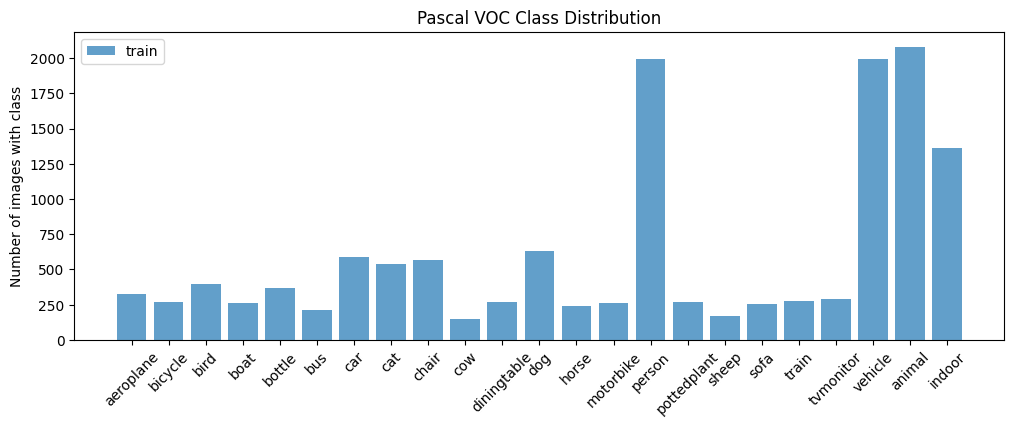

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load labels (adjust path if needed)
spmll_path = "spmll"
train_labels = np.load(spmll_path + "/data/pascal/formatted_train_labels_hier.npy")
# val_labels   = np.load(spmll_path + "/data/pascal/formatted_val_labels.npy")

print("Train labels shape:", train_labels.shape)  # (num_train, 20)
# print("Val labels shape:", val_labels.shape)      # (num_val, 20)
print("sun of train labels", train_labels.sum())

# Count frequency per class
train_counts = train_labels.sum(axis=0)
# val_counts   = val_labels.sum(axis=0)

# Map IDs → names
catID_to_catName = {
    0: "aeroplane",
    1: "bicycle",
    2: "bird",
    3: "boat",
    4: "bottle",
    5: "bus",
    6: "car",
    7: "cat",
    8: "chair",
    9: "cow",
    10: "diningtable",
    11: "dog",
    12: "horse",
    13: "motorbike",
    14: "person",
    15: "pottedplant",
    16: "sheep",
    17: "sofa",
    18: "train",
    19: "tvmonitor",
    20: "vehicle",
    21: "animal",
    22: "indoor",
}

# Print counts
for i in range(23):
    print(f"{i:2d} {catID_to_catName[i]:12s} | train={int(train_counts[i])}")

# Plot distribution
plt.figure(figsize=(12, 4))
plt.bar(range(23), train_counts, alpha=0.7, label="train")
# plt.bar(range(20), val_counts, alpha=0.7, label="val")
plt.xticks(range(23), [catID_to_catName[i] for i in range(23)], rotation=45)
plt.ylabel("Number of images with class")
plt.legend()
plt.title("Pascal VOC Class Distribution")
plt.show()

Train labels obs shape: (5717, 23)
 0 aeroplane    | train=173
 1 bicycle      | train=92
 2 bird         | train=188
 3 boat         | train=106
 4 bottle       | train=123
 5 bus          | train=80
 6 car          | train=240
 7 cat          | train=231
 8 chair        | train=164
 9 cow          | train=65
10 diningtable  | train=69
11 dog          | train=250
12 horse        | train=99
13 motorbike    | train=114
14 person       | train=982
15 pottedplant  | train=95
16 sheep        | train=67
17 sofa         | train=88
18 train        | train=118
19 tvmonitor    | train=100
20 vehicle      | train=828
21 animal       | train=970
22 indoor       | train=475


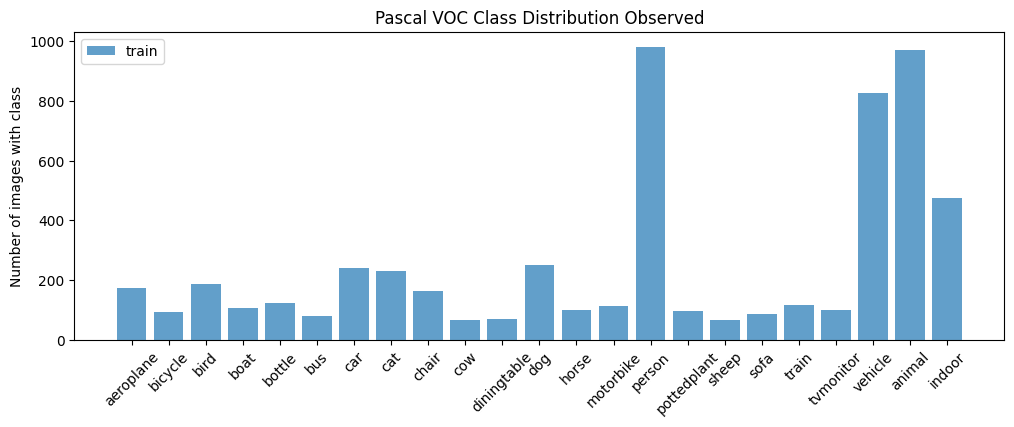

In [4]:
import numpy as np
import matplotlib.pyplot as plt

train_labels = np.load(spmll_path + "/data/pascal/formatted_train_labels_obs.npy")
print("Train labels obs shape:", train_labels.shape)  # (num_train, 20)


# Count frequency per class
train_counts = train_labels.sum(axis=0)
# val_counts   = val_labels.sum(axis=0)

# Map IDs → names
catID_to_catName = {
    0: "aeroplane",
    1: "bicycle",
    2: "bird",
    3: "boat",
    4: "bottle",
    5: "bus",
    6: "car",
    7: "cat",
    8: "chair",
    9: "cow",
    10: "diningtable",
    11: "dog",
    12: "horse",
    13: "motorbike",
    14: "person",
    15: "pottedplant",
    16: "sheep",
    17: "sofa",
    18: "train",
    19: "tvmonitor",
    20: "vehicle",
    21: "animal",
    22: "indoor",
}

# Print counts
for i in range(23):
    print(f"{i:2d} {catID_to_catName[i]:12s} | train={int(train_counts[i])}")

# Plot distribution
plt.figure(figsize=(12,4))
plt.bar(range(23), train_counts, alpha=0.7, label="train")
# plt.bar(range(20), val_counts, alpha=0.7, label="val")
plt.xticks(range(23), [catID_to_catName[i] for i in range(23)], rotation=45)
plt.ylabel("Number of images with class")
plt.legend()
plt.title("Pascal VOC Class Distribution Observed")
plt.show()



In [ ]:
train_labels.sum()

5717.0